In [7]:
from pathlib import Path

import networkx as nx
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import linkage, dendrogram

from src.setup.setup_data import setup_train_x_data
from src.typing.xdata import XData

In [23]:
dtypes = {'buildingblock1_smiles': np.int16, 'buildingblock2_smiles': np.int16, 'buildingblock3_smiles': np.int16,
          'binds_BRD4':np.byte, 'binds_HSA':np.byte, 'binds_sEH':np.byte}

train = pd.read_csv('/home/daniel-de-dios/PycharmProjects/q4-detect-medicine/data/shrunken/train.csv', dtype = dtypes, nrows=1000000)
train_samples = train.sample(frac = 0.01)

object_data = setup_train_x_data(Path("/home/daniel-de-dios/PycharmProjects/q4-detect-medicine/data/shrunken/"), train_samples)

In [34]:
all_smiles = object_data.bb1_smiles + object_data.bb2_smiles + object_data.bb3_smiles
mols = [Chem.MolFromSmiles(smile) for smile in all_smiles]
fingerprints = [AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024) for mol in mols]

# Calculate similarity matrix
def tanimoto_similarity(fp1, fp2):
    return np.double(AllChem.DataStructs.TanimotoSimilarity(fp1, fp2))

similarity_matrix = np.zeros((len(fingerprints), len(fingerprints)))
for i in range(len(fingerprints)):
    for j in range(len(fingerprints)):
        similarity_matrix[i, j] = tanimoto_similarity(fingerprints[i], fingerprints[j])

/tmp/ipykernel_15595/2149597002.py:1: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(1 - similarity_matrix, 'average')  # '1 - similarity' to convert similarity to distance


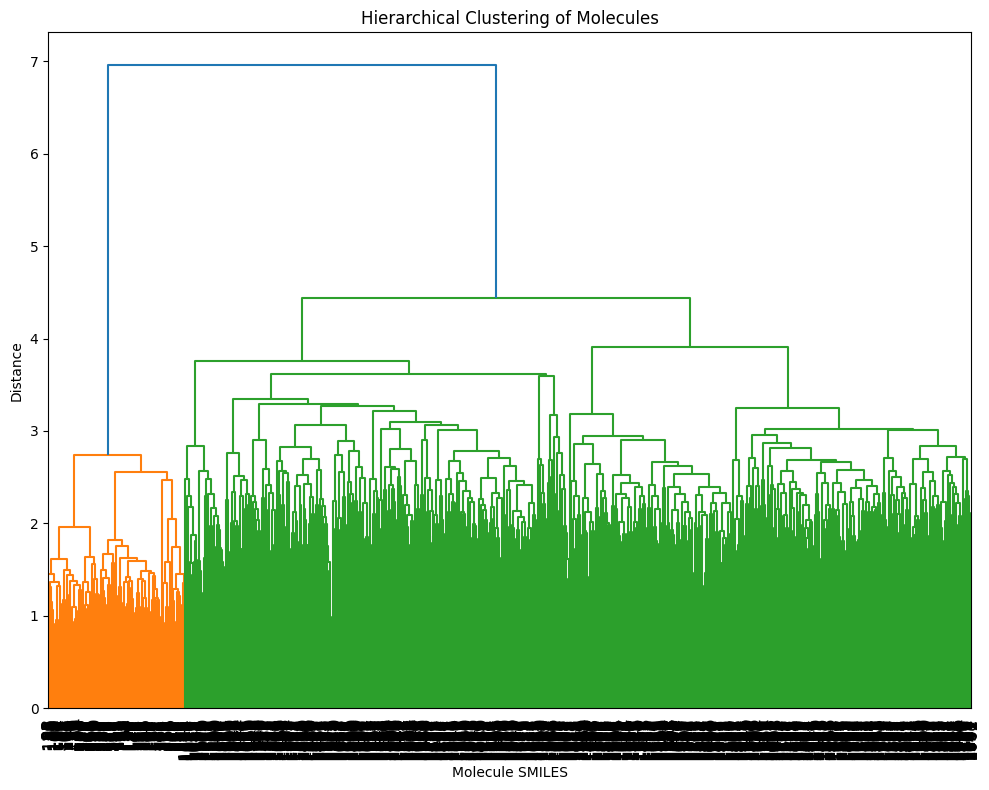

In [28]:
Z = linkage(1 - similarity_matrix, 'average')  # '1 - similarity' to convert similarity to distance

# Plot Dendrogram
plt.figure(figsize=(10, 8))
dendrogram(Z, leaf_rotation=90., leaf_font_size=12.)
plt.title('Hierarchical Clustering of Molecules')
plt.xlabel('Molecule SMILES')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

Finished


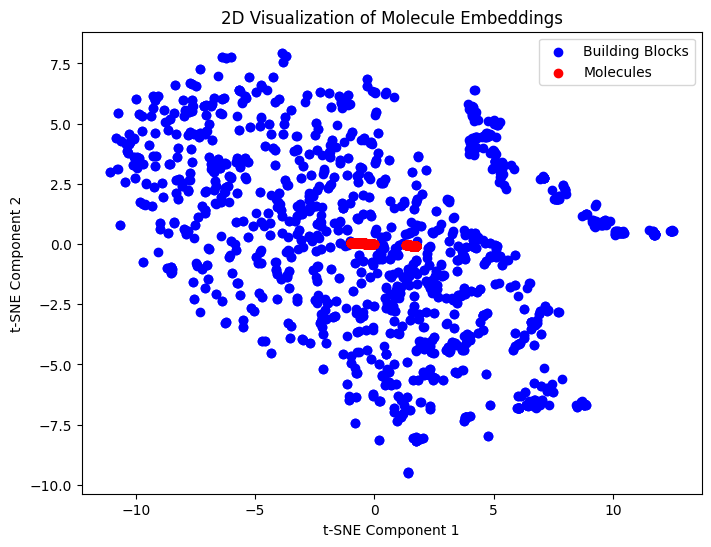

In [35]:
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from rdkit import Chem

def smiles_to_embeddings(smiles):
    # Convert SMILES to molecule
    mol = Chem.MolFromSmiles(smiles)
    # Get a simple fingerprint: replace with actual embedding generation
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
    return np.array(fp)

# Generating embeddings
embeddings_bb = np.array([smiles_to_embeddings(smile) for smile in all_smiles])
embeddings_mol = np.array([smiles_to_embeddings(smile) for smile in object_data.molecule_smiles])

# Applying t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
tsne_results = tsne.fit_transform(embeddings_bb)
print("Finished")
tsne_2 = TSNE(n_components=2, perplexity=30, n_iter=250)
tsne_2_results = tsne_2.fit_transform(embeddings_mol)

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c='blue', label='Building Blocks')
plt.scatter(tsne_2_results[:, 0], tsne_2_results[:, 1], c='red', label='Molecules')

plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('2D Visualization of Molecule Embeddings')
plt.legend()
plt.show()


In [38]:
print(len(object_data.bb1_smiles), len(object_data.bb2_smiles), len(object_data.bb3_smiles))
print(len(object_data.molecule_smiles))

271 693 872
10000
